Notebook purpose

- Develop analysis code

In [1]:
import contextlib
import math
import os
import re
import sys

import linearmodels as lm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.analysis.helpers as ah
import entropy.analysis.sumstats_table as ss
import entropy.data.cleaners as cl
import entropy.data.selectors as sl
import entropy.figures.figures as ff
import entropy.figures.helpers as fh
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

SAMPLE = "XX7"

In [2]:
import warnings

warnings.filterwarnings("once")

## Data description

**Read transactions data**

In [3]:
# dft = hd.read_txn_data("777")
# hd.inspect(dft)

**Read analysis data**

In [10]:
def binary_inflows(df):
    df["has_sa_inflows"] = df.sa_inflows.gt(0).astype(int)
    return df


def log_income(df):
    for col in ["monthly_income", "annual_income"]:
        df["_".join(["log", col])] = df[col].where(df[col] == 0, np.log(df[col]))
    return df


def time_as_month(df):
    return (
        df.reset_index("date")
        .assign(month=lambda df: df.date.dt.month)
        .set_index("month", append=True)
    )


def standardise_entropy(df):
    df["entropy_sptac_std"] = (
        df.entropy_sptac - df.entropy_sptac.mean()
    ) / df.entropy_sptac.std()
    return df


def absolute_tag_spends(df):
    tag_spends = df.filter(like="prop_spend")
    for c in tag_spends:
        df[c.replace("prop_", "")] = df[c] * df.monthly_spend
    return df


def rename(df):
    return df.rename(columns={"monthly_spend": "spend_month"})


def winsorise_outliers(df):
    for c in df.filter(regex="^spend_|annual_income"):
        df[c] = hd.winsorise(df[c], pct=1, how="upper")
    return df


def squares(df):
    cols = df.filter(regex="annual_income|age")
    for col in cols:
        df["_".join([col, "sq"])] = df[col] ** 2
    return df


df = (
    hd.read_analysis_data(SAMPLE)
    .pipe(binary_inflows)
    .pipe(log_income)
    .pipe(time_as_month)
    .pipe(standardise_entropy)
    .pipe(absolute_tag_spends)
    .pipe(rename)
    .pipe(winsorise_outliers)
    .pipe(squares)
)

hd.inspect(df)

Time for read_analysis_data            : 2.04 seconds
(84,096, 45)


/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


date                   active_accounts  txns_count  \
user_id month                                                            
37      2     2012-02-29  [287407, 287405, 287406, 287404]          22   
        3     2012-03-31  [287405, 287407, 287406, 287404]          16   

                txns_value  txn_count_sa  txn_count_ca  spend_month  \
user_id month                                                         
37      2      9495.810547           3.0           8.0   528.239990   
        3      2147.699951           2.0           9.0   429.880005   

               log_monthly_spend  prop_spend_services  prop_spend_other_spend  \
user_id month                                                                   
37      2               6.269551             0.224898                0.088596   
        3               6.063506             0.028799                0.093049   

               prop_spend_household  prop_spend_travel  \
user_id month                                            
37      2                  0.591852                0.0   
        3                  0.761841                0.0   

               prop_spend_communication  prop_spend_finance  prop_spend_motor  \
user_id month                                                                   
37      2                      0.094654                 0.0               0.0   
        3                      0.116312                 0.0               0.0   

               prop_spend_retail  prop_spend_hobbies  monthly_income  \
user_id month                                                          
37      2                    0.0                 0.0     1687.530029   
        3                    0.0                 0.0     1085.790039   

               annual_income  entropy_sptac    region   age  female  \
user_id month                                                         
37      2       18768.632812       2.899397  Scotland  27.0     0.0   
        3       18768.632812       3.039149  Scotland  27.0     0.0   

               sa_inflows  sa_outflows  sa_net_inflows  sa_scaled_inflows  \
user_id month                                                               
37      2          3340.0       1740.0          1600.0           2.135478   
        3             0.0          0.0             0.0           0.000000   

               sa_scaled_outflows  sa_scaled_net_inflows  has_sa_inflows  \
user_id month                                                              
37      2                1.112494               1.022983               1   
        3                0.000000               0.000000               0   

               log_monthly_income  log_annual_income  entropy_sptac_std  \
user_id month                                                             
37      2                7.431021           9.839942            1.44949   
        3                6.990063           9.839942            2.05746   

               spend_services  spend_other_spend  spend_household  \
user_id month                                                       
37      2          118.800003          46.799999       312.640015   
        3           12.380000          40.000000       327.500000   

               spend_travel  spend_communication  spend_finance  spend_motor  \
user_id month                                                                  
37      2               0.0                 50.0            0.0          0.0   
        3               0.0                 50.0            0.0          0.0   

               spend_retail  spend_hobbies  annual_income_sq  age_sq  \
user_id month                                                          
37      2               0.0            0.0      3.522616e+08   729.0   
        3               0.0            0.0      3.522616e+08   729.0   

               log_annual_income_sq  
user_id month                        
37      2                 96.824464  
        3                 96.824464

**Sample selection - see paper**

**Number of unique users**

In [11]:
df.index.get_level_values("user_id").nunique()

2777

**Number of months we observe users for**

count    2777.000000
mean       30.283039
std        17.556614
min         6.000000
25%        16.000000
50%        26.000000
75%        41.000000
max       102.000000
dtype: float64


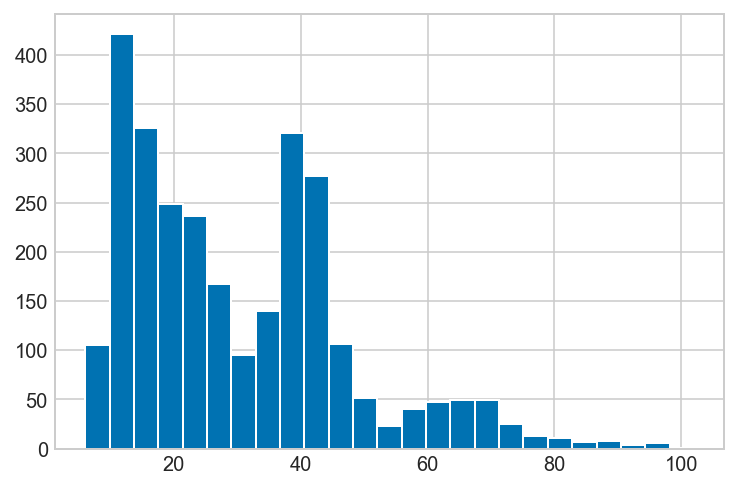

In [12]:
user_months = df.groupby("user_id").size()
print(user_months.describe())
user_months.hist(bins=25);

**User characteristics**

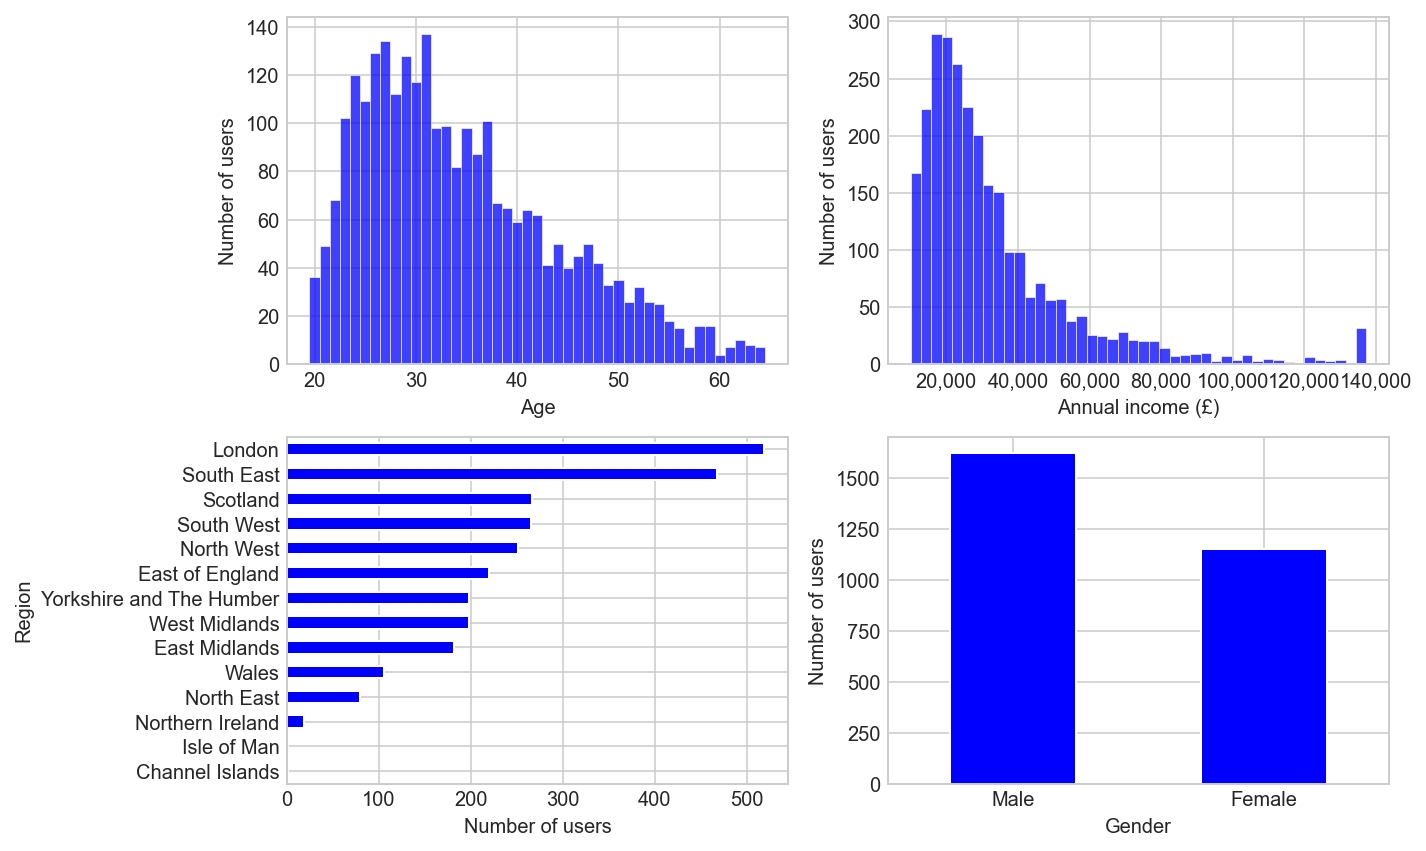

In [13]:
ff.user_chars(df, write=False)

**Summary statistics**

In [14]:
ss.main(df, write=False)

,count,mean,std,min,max,25%,50%,75%
txns_count,84096.0,1.114329e+02,6.234494e+01,6.000000e+00,9.700000e+02,7.000000e+01,9.900000e+01,1.380000e+02
txns_value,84096.0,2.057620e+04,1.035111e+05,2.543500e+02,2.139299e+07,5.994772e+03,1.020117e+04,1.890812e+04
txn_count_sa,84096.0,4.289051e+00,8.646355e+00,0.000000e+00,3.890000e+02,0.000000e+00,2.000000e+00,5.000000e+00
txn_count_ca,84096.0,9.155378e+01,5.378481e+01,5.000000e+00,9.060000e+02,5.500000e+01,8.100000e+01,1.160000e+02
spend_month,84096.0,2.723634e+03,2.591703e+03,2.007700e+02,1.725381e+04,1.221357e+03,1.954375e+03,3.256315e+03
log_monthly_spend,84096.0,7.617547e+00,7.678196e-01,5.302160e+00,1.298465e+01,7.107718e+00,7.577826e+00,8.088352e+00
prop_spend_services,84096.0,1.916064e-01,1.425461e-01,0.000000e+00,1.000000e+00,8.956609e-02,1.572610e-01,2.567938e-01
prop_spend_other_spend,84096.0,1.249679e-01,1.386204e-01,0.000000e+00,1.000000e+00,2.946656e-02,7.969816e-02,1.710504e-01
prop_spend_household,84096.0,3.635733e-01,2.039986e-01,0.000000e+00,1.000000e+00,2.047645e-01,3.454602e-01,5.055782e-01
prop_spend_travel,84096.0,5.139969e-02,9.704310e-02,0.000000e+00,9.785931e-01,0.000000e+00,1.222656e-02,5.675299e-02


## Independent variable - entropy

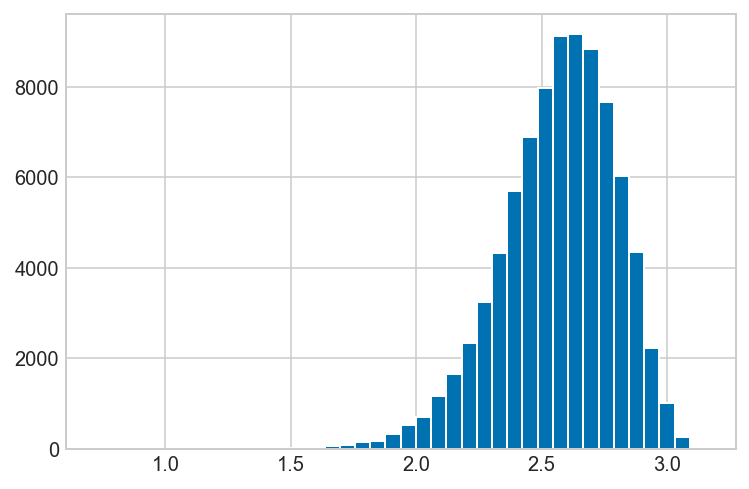

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x1661ed640>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


In [15]:
df.entropy_sptac.hist(bins=40);

## Main results

In [25]:
list(data.filter(regex="^spend_").columns)

['spend_month',
 'spend_services',
 'spend_other_spend',
 'spend_household',
 'spend_travel',
 'spend_communication',
 'spend_finance',
 'spend_motor',
 'spend_retail',
 'spend_hobbies']

In [23]:
data = df

y = data["has_sa_inflows"]
prop_spends = list(data.filter(regex="^spend_").columns)[:-1]
other_controls = ["annual_income", "age"]
var_of_interest = ["entropy_sptac_std"]
exog = data[var_of_interest + other_controls + prop_spends]

results = lm.panel.compare(
    [
        ah.fe_reg(
            y,
            data[var_of_interest],
            entity_effects=True,
            time_effects=True,
        ),
        ah.fe_reg(
            y,
            data[var_of_interest + ["age"]],
            entity_effects=True,
            time_effects=True,
        ),
        ah.fe_reg(
            y,
            data[var_of_interest + ["annual_income"]],
            entity_effects=True,
            time_effects=True,
        ),
        ah.fe_reg(
            y,
            data[var_of_interest + prop_spends],
            entity_effects=True,
            time_effects=True,
        ),
        ah.fe_reg(y, exog, entity_effects=True, time_effects=True),
        ah.fe_reg(y, exog, entity_effects=True, time_effects=False),
        ah.fe_reg(y, exog, entity_effects=False, time_effects=True),
        ah.fe_reg(y, exog, entity_effects=False, time_effects=False),
    ],
    stars=True,
)
print(results)

                                                                                Model Comparison                                                                               
                                   Model 0            Model 1            Model 2            Model 3            Model 4            Model 5            Model 6            Model 7
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable               has_sa_inflows     has_sa_inflows     has_sa_inflows     has_sa_inflows     has_sa_inflows     has_sa_inflows     has_sa_inflows     has_sa_inflows
Estimator                         PanelOLS           PanelOLS           PanelOLS           PanelOLS           PanelOLS           PanelOLS           PanelOLS           PanelOLS
No. Observations                     84093              84093              84093              84093              84093  

In [22]:
4.417e-6 * 100

0.0004417